# Deep Neural NetworkによるJGB利回り変化の予測  
Deep Neural Network(DNN)を使い、10日後のJGB利回りの変化を予測する。  
入力値として直近50日間のJGB利回りの推移と季節性のフラグを用いる。  
元データは財務省HPで公開されているものを使用。  
http://www.mof.go.jp/jgbs/reference/interest_rate/index.htm  

JGB利回りのデータの取得にあたって以下のモジュールを使用。  
https://github.com/MitsuruFujiwara/JGBScraping

#### 事前準備  
必要なパッケージのロード

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.externals import joblib
from keras.models import load_model
from xgboost import XGBClassifier, XGBRegressor, plot_importance

from JGBScraping import JGBScraping

%matplotlib inline

Using TensorFlow backend.
/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


必要な関数の定義

In [2]:
# シフトさせたデータ取得用
def getShifted(df, numLag):
    res = {}
    col = []
    for t in range(1, numLag+1):
        label = 't_' + str(t)
        col.append(label)
        res[label] = df.shift(t)
    return pd.DataFrame(res, index=df.index, columns=col)

JGBのヒストリカルデータを取得

In [3]:
jgbscraping = JGBScraping()
jgb = jgbscraping.getAllData()
jgb.head()

,JGB_1Y,JGB_2Y,JGB_3Y,JGB_4Y,JGB_5Y,JGB_6Y,JGB_7Y,JGB_8Y,JGB_9Y,JGB_10Y,JGB_15Y,JGB_20Y,JGB_25Y,JGB_30Y,JGB_40Y
1974-09-24,10.327,9.362,8.830,8.515,8.348,8.290,8.24,8.121,8.127,NaN,NaN,NaN,NaN,NaN,NaN
1974-09-25,10.333,9.364,8.831,8.516,8.348,8.290,8.24,8.121,8.127,NaN,NaN,NaN,NaN,NaN,NaN
1974-09-26,10.340,9.366,8.832,8.516,8.348,8.290,8.24,8.122,8.128,NaN,NaN,NaN,NaN,NaN,NaN
1974-09-27,10.347,9.367,8.833,8.517,8.349,8.290,8.24,8.122,8.128,NaN,NaN,NaN,NaN,NaN,NaN
1974-09-28,10.354,9.369,8.834,8.518,8.349,8.291,8.24,8.122,8.129,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
jgb.shape

(11229, 15)

In [5]:
jgb.dtypes

JGB_1Y     float64
JGB_2Y     float64
JGB_3Y     float64
JGB_4Y     float64
JGB_5Y     float64
JGB_6Y     float64
JGB_7Y     float64
JGB_8Y     float64
JGB_9Y     float64
JGB_10Y    float64
JGB_15Y    float64
JGB_20Y    float64
JGB_25Y    float64
JGB_30Y    float64
JGB_40Y    float64
dtype: object

季節性のフラグを生成

In [6]:
_day = pd.get_dummies(jgb.index.day, drop_first=True, prefix='day_').astype(int) #日付
_month = pd.get_dummies(jgb.index.month, drop_first=True, prefix='month_').astype(int) #月
_weekday = pd.get_dummies(jgb.index.weekday, drop_first=True, prefix='weekday_').astype(int) #曜日
_weekofyear = pd.get_dummies(jgb.index.weekofyear, drop_first=True, prefix='weekofyear_').astype(int) #年の何週目か
season = pd.concat([_day, _month, _weekday, _weekofyear],axis=1)
season.index = jgb.index
season.head()

,day__2,day__3,day__4,day__5,day__6,day__7,day__8,day__9,day__10,day__11,...,weekofyear__44,weekofyear__45,weekofyear__46,weekofyear__47,weekofyear__48,weekofyear__49,weekofyear__50,weekofyear__51,weekofyear__52,weekofyear__53
1974-09-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1974-09-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1974-09-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1974-09-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1974-09-28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 基礎分析  
10Y利回りの推移

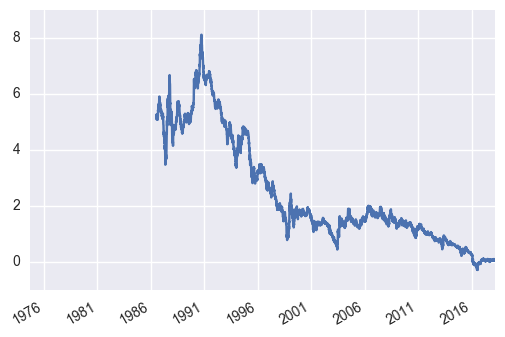

In [7]:
jgb.JGB_10Y.plot.line()

10日間の変化幅の分布

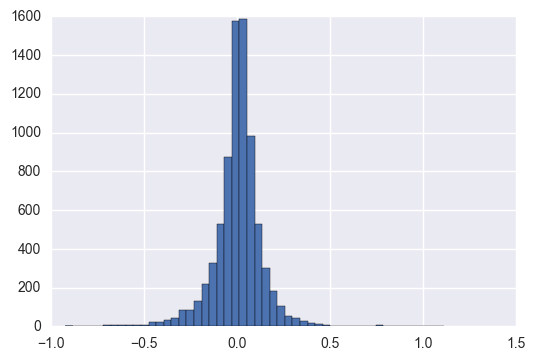

In [8]:
jgb.JGB_10Y.diff(-10).hist(bins=50)

10日間の変化幅の推移

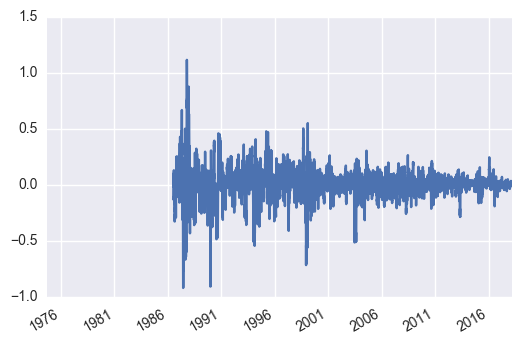

In [9]:
jgb.JGB_10Y.diff(-10).plot.line()

#### データ加工
クラス分類問題用のデータセットを生成

In [10]:
df_class = getShifted(jgb.JGB_10Y.diff(),50).dropna() # シフトさせたデータの追加
df_class = pd.concat([df_class, season], axis=1).dropna() # 季節性フラグのデータと結合
df_class['label'] = jgb.JGB_10Y.diff(-10).map(lambda x: 1 if x >=0 else 0) # 10日間の変化幅からラベルを生成（上昇:1, 低下:0）
df_class.head()

,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,...,weekofyear__45,weekofyear__46,weekofyear__47,weekofyear__48,weekofyear__49,weekofyear__50,weekofyear__51,weekofyear__52,weekofyear__53,label
1986-09-06,0.000,-0.017,0.076,0.015,0.114,-0.003,0.000,0.016,0.013,0.000,...,0,0,0,0,0,0,0,0,0,0
1986-09-08,0.115,0.000,-0.017,0.076,0.015,0.114,-0.003,0.000,0.016,0.013,...,0,0,0,0,0,0,0,0,0,0
1986-09-09,-0.027,0.115,0.000,-0.017,0.076,0.015,0.114,-0.003,0.000,0.016,...,0,0,0,0,0,0,0,0,0,0
1986-09-10,-0.002,-0.027,0.115,0.000,-0.017,0.076,0.015,0.114,-0.003,0.000,...,0,0,0,0,0,0,0,0,0,0
1986-09-11,0.000,-0.002,-0.027,0.115,0.000,-0.017,0.076,0.015,0.114,-0.003,...,0,0,0,0,0,0,0,0,0,0


回帰問題用のデータセットを生成

In [11]:
df_reg = getShifted(jgb.JGB_10Y.diff(),50).dropna() # シフトさせたデータの追加
df_reg = pd.concat([df_reg, season], axis=1).dropna() # 季節性フラグのデータと結合
df_reg['label'] = jgb.JGB_10Y.diff(-10) # 10日間の変化幅そのものをラベルに
df_reg.head()

,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,...,weekofyear__45,weekofyear__46,weekofyear__47,weekofyear__48,weekofyear__49,weekofyear__50,weekofyear__51,weekofyear__52,weekofyear__53,label
1986-09-06,0.000,-0.017,0.076,0.015,0.114,-0.003,0.000,0.016,0.013,0.000,...,0,0,0,0,0,0,0,0,0,-0.132
1986-09-08,0.115,0.000,-0.017,0.076,0.015,0.114,-0.003,0.000,0.016,0.013,...,0,0,0,0,0,0,0,0,0,-0.142
1986-09-09,-0.027,0.115,0.000,-0.017,0.076,0.015,0.114,-0.003,0.000,0.016,...,0,0,0,0,0,0,0,0,0,-0.141
1986-09-10,-0.002,-0.027,0.115,0.000,-0.017,0.076,0.015,0.114,-0.003,0.000,...,0,0,0,0,0,0,0,0,0,-0.183
1986-09-11,0.000,-0.002,-0.027,0.115,0.000,-0.017,0.076,0.015,0.114,-0.003,...,0,0,0,0,0,0,0,0,0,-0.125


訓練データ（1986/9〜2016/12）と検証データ（2017/1〜）に分割

In [12]:
df_class_train = df_class[:'2016/12/31']
df_class_test  = df_class['2016/12/31':]
trX_c, trY_c = np.array(df_class_train.drop('label', axis=1)), np.array(df_class_train.label)
valX_c, valY_c = np.array(df_class_test.drop('label', axis=1)), np.array(df_class_test.label)

In [13]:
df_reg_train = df_reg[:'2016/12/31']
df_reg_test  = df_reg['2016/12/31':]
trX_r, trY_r = np.array(df_reg_train.drop('label', axis=1)), np.array(df_reg_train.label)
valX_r, valY_r = np.array(df_reg_test.drop('label', axis=1)), np.array(df_reg_test.label)

加工済みのデータを保存

In [14]:
df_class_train.to_hdf('data.h5', key='train_class')
df_class_test.to_hdf('data.h5', key='test_class')
df_reg_train.to_hdf('data.h5', key='train_reg')
df_reg_test.to_hdf('data.h5', key='test_reg')

### モデルの検証  
以降では事前学習ありのDeep Neural Network(DNN)による予測精度を検証する。  

#### クラス分類モデル  
別途推定したモデルをロード

In [15]:
dnn_c=load_model('DNN_C.h5')

モデルをコンパイル

In [16]:
dnn_c.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

モデルのサマリー

In [17]:
dnn_c.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 148)           22052       dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 148)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 148)           0           activation_1[0][0]               
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 148)           22052       dropout_1[0][0]                  
___________________________________________________________________________________________

モデルのスコアを算出（検証データ）

In [18]:
score_c_test = dnn_c.evaluate(valX_c, valY_c)

 32/299 [==>...........................] - ETA: 2s

In [19]:
'loss: ' + str(score_c_test[0])

'loss: 0.7153600767304666'

In [20]:
'Accuracy: ' + str(score_c_test[1])

'Accuracy: 0.5752508357217081'

モデルのスコアを算出（訓練データ）

In [21]:
score_c_train = dnn_c.evaluate(trX_c, trY_c)

6752/7518 [=========================>....] - ETA: 0s

In [22]:
'loss: ' + str(score_c_train[0])

'loss: 0.6325120856134648'

In [23]:
'Accuracy: ' + str(score_c_train[1])

'Accuracy: 0.679169992050867'

#### 回帰モデル  

In [24]:
# TODO

#### 予測値の保存

In [25]:
# 検証データの保存
predict_test = {}
predict_test['model'] = dnn_c.predict_classes(valX_c)[:, 0]
predict_test['act'] = valY_c
predict_test['act_diff'] = valY_r
predict_test = pd.DataFrame(predict_test)
predict_test.index = df_class_test.index
predict_test.to_csv('predict_test.csv')

 32/299 [==>...........................] - ETA: 0s

In [26]:
# 訓練データの保存
predict_train = {}
predict_train['model'] = dnn_c.predict_classes(trX_c)[:, 0]
predict_train['act'] = trY_c
predict_train['act_diff'] = trY_r
predict_train = pd.DataFrame(predict_train)
predict_train.index = df_class_train.index
predict_train.to_csv('predict_train.csv')

7296/7518 [============================>.] - ETA: 0s